In [1]:
import os
#name = input("Enter your name:")
#print(name)
print(os.getcwd())

/Users/naellini


                     Recv_Pkts    Name  Recv_Bytes  Sent_Bytes  Sent_Pkts
Time                                                                     
2018-06-09 09:23:23     166460  BD-1-6   249691335   267631998     178421
2018-06-09 09:23:28     149297  BD-1-6   223945753   239823342     159882
2018-06-09 09:23:33     176106  BD-1-6   264159298   261569754     174379
2018-06-09 09:23:38     154597  BD-1-6   231896303   257914831     171943
2018-06-09 09:23:43     144741  BD-1-6   217112917   215670977     143780


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2527d908>,
      dtype=object)

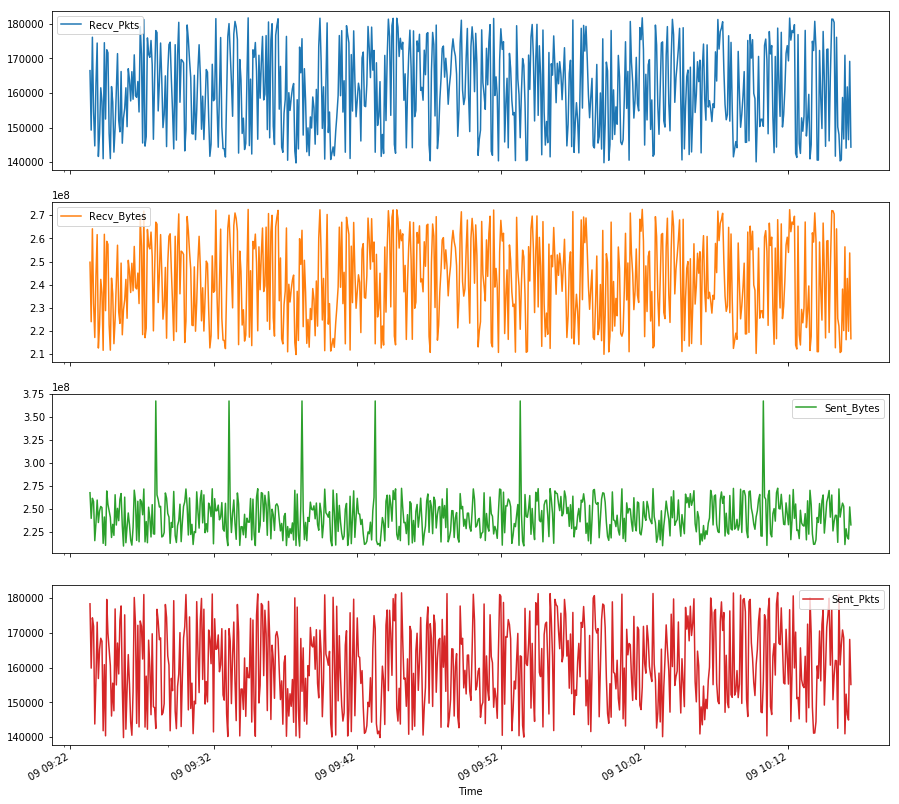

In [21]:
#import pandas.io.data as web
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import numpy as np
import matplotlib.pylab as plt

def parser(x):
    return datetime.strptime(x, '%Y/%m')

#series = read_csv('ml_part1.csv', header=0, parse_dates=['Time'], index_col='Time', squeeze=True, date_parser=parser)
#series = read_csv('ml_part1.csv')
t_series = read_csv('ml_part1_new.csv', header=0, parse_dates=['Time'], index_col='Time', squeeze=True)
series = t_series[t_series['Name']=='BD-1-6']
print(series.head())
series.plot(subplots=True,figsize=(15, 15))


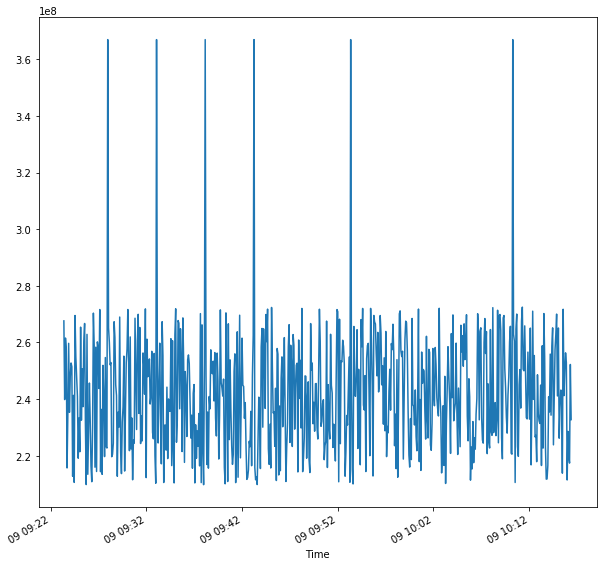

In [3]:
series.Sent_Bytes.plot(figsize=(10, 10))

In [4]:
ts = series['Sent_Bytes']
ts.head(10)

Time
2018-06-09 09:23:23    267631998
2018-06-09 09:23:28    239823342
2018-06-09 09:23:33    261569754
2018-06-09 09:23:38    257914831
2018-06-09 09:23:43    215670977
2018-06-09 09:23:48    235001350
2018-06-09 09:23:53    259696548
2018-06-09 09:23:58    235319171
2018-06-09 09:24:03    247929034
2018-06-09 09:24:08    252749917
Name: Sent_Bytes, dtype: int64

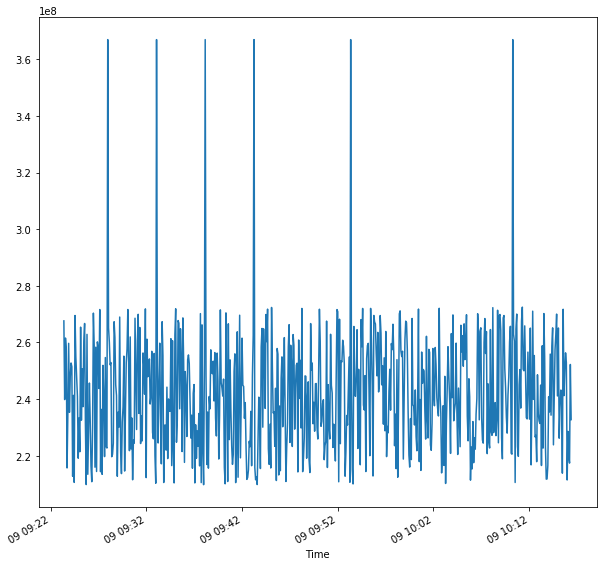

In [5]:
ts.plot(figsize=(10, 10))

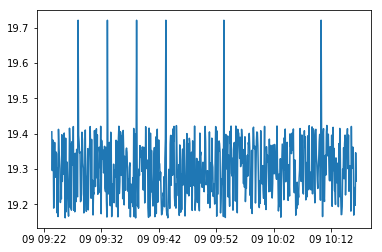

In [6]:
#One of the first tricks to reduce trend can be transformation.
#So we can apply transformation which penalize higher values more than smaller values. 
#These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity
ts_log = np.log(ts)
plt.plot(ts_log)

In [7]:
#Testing stationarity with rolling mean and SD
from statsmodels.tsa.stattools import adfuller
def test_the_stationarity(timeseries):
    
    #Determing rolling statistics
    moving_avg = ts_log.rolling(12).mean()
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()    
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

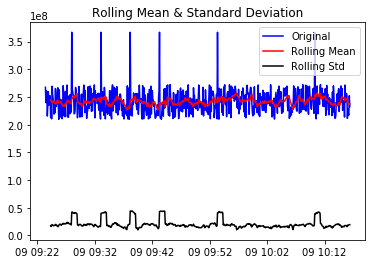

Results of Dickey-Fuller Test:
Test Statistic                -1.875639e+01
p-value                        2.026929e-30
#Lags Used                     1.000000e+00
Number of Observations Used    6.340000e+02
Critical Value (1%)           -3.440706e+00
Critical Value (5%)           -2.866110e+00
Critical Value (10%)          -2.569203e+00
dtype: float64


In [8]:
test_the_stationarity(ts)

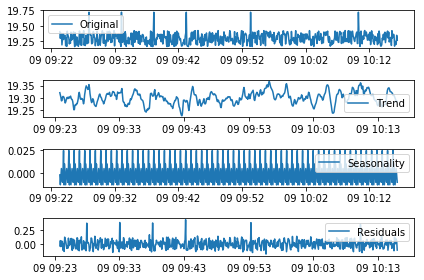

In [9]:
#Eliminating trend and Seasonality Decomposing
#Both trend and seasonality are modeled separately and the remaining part of the series is returned

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,freq=10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

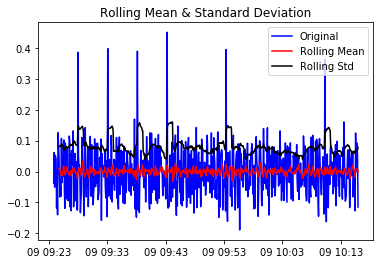

Results of Dickey-Fuller Test:
Test Statistic                -1.093147e+01
p-value                        9.798722e-20
#Lags Used                     1.900000e+01
Number of Observations Used    6.060000e+02
Critical Value (1%)           -3.441187e+00
Critical Value (5%)           -2.866321e+00
Critical Value (10%)          -2.569316e+00
dtype: float64


In [10]:
#Trend, seasonality are separated out from data and we can model the residuals. And check stationarity of residuals.
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_the_stationarity(ts_log_decompose)

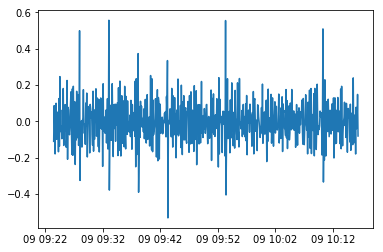

In [11]:
#Eliminating trend and Seasonality with differencing method
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

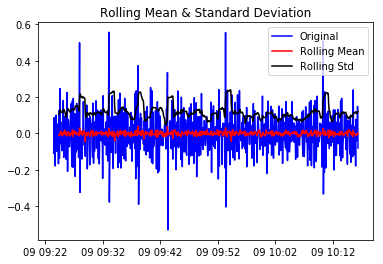

Results of Dickey-Fuller Test:
Test Statistic                -1.176176e+01
p-value                        1.143527e-21
#Lags Used                     1.500000e+01
Number of Observations Used    6.190000e+02
Critical Value (1%)           -3.440958e+00
Critical Value (5%)           -2.866221e+00
Critical Value (10%)          -2.569263e+00
dtype: float64


In [12]:
#Testing stationarity with rolling mean and SD after removing Trend/Seasonality
ts_log_diff.dropna(inplace=True)
test_the_stationarity(ts_log_diff)

In [13]:
#ACF and PACF plots to determine p,d,f
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=100)
lag_pacf = pacf(ts_log_diff, nlags=100, method='ols')

Text(0.5,1,'Autocorrelation Function')

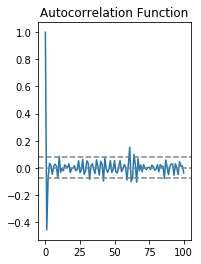

In [14]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

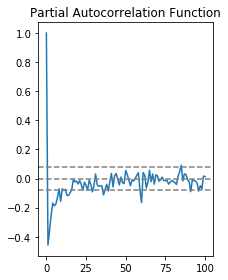

In [15]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/naellini/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/naellini/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/naellini/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 4.7073')

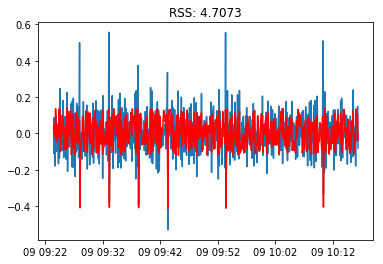

In [16]:
# ARIMA Modeling
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1) 

plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [17]:
# Taking it back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Time
2018-06-09 09:23:28    0.000017
2018-06-09 09:23:33    0.053594
2018-06-09 09:23:38   -0.020257
2018-06-09 09:23:43   -0.004971
2018-06-09 09:23:48    0.135276
dtype: float64


In [18]:
# Cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Time
2018-06-09 09:23:28    0.000017
2018-06-09 09:23:33    0.053612
2018-06-09 09:23:38    0.033354
2018-06-09 09:23:43    0.028384
2018-06-09 09:23:48    0.163659
dtype: float64


In [19]:
#create a series with all values as base number and add the differences to it.
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Time
2018-06-09 09:23:23    19.405123
2018-06-09 09:23:28    19.405141
2018-06-09 09:23:33    19.458735
2018-06-09 09:23:38    19.438478
2018-06-09 09:23:43    19.433507
dtype: float64

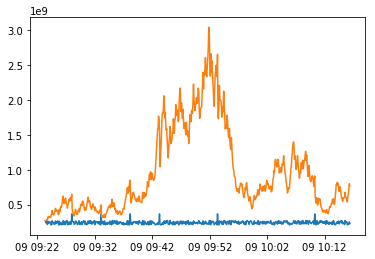

In [20]:
#Take the exponent and compare with the original series.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))